# Satellite Imagery Dataset
The goal here is to obtain true-color satellite imagery from a reputable source. That means any generated simulations of satellite data (such as fake layers) are prohibited since we want the model to predict on **real** photographs of Earth.

Microsoft's Planetary Computer (https://planetarycomputer.microsoft.com/explore) gives us datasets from Harmonized Landsat and Sentinel-2 (HLS) v2.0 at 30 meter resolution (https://hls.gsfc.nasa.gov/products-description/s30). The coverage of the world is extensive, and this will be the dataset of choice. To obtain this dataset, first install relevant dependencies:

In [1]:
%pip install pystac_client
%pip install planetary_computer
%pip install stackstac
%pip install rasterio
%pip install contextily
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Data Collection Strategy
To ensure equal coverage of most human settlements in the world, I will select six bounding boxes, each representing a geographical area of human activity for every inhabited continent. *Europe and Asia will be considered separate continents since analysis is done on human and not natural geography.*

Some additional selection optimizations:
1. For North America, much of northern Canada and all of Alaska will be cut off due to low population density.
2. For Asia, much of the Siberian wilderness and the Eurasian Steppe will be omitted due to low population density.
3. For South America, most of Patagonia will be cut off due to sparse population density.
4. For Africa, most imagery will be selected from a bounding box that focuses on sub-Sahara due to similar reasons as above.
5. Australia's outback will be **kept** to see how the model performs.

Edge cases, such as ocean data and Antarctica, may appear sporadically but are not the main focus of the model.

In [2]:
north_america = {
  "type": "Polygon",
  "coordinates": [
    [
      [-123.54616502112671, 23.88233226135401],
      [-74.11047877575395, 23.88233226135401],
      [-74.11047877575395, 50.74402394325389],
      [-123.54616502112671, 50.74402394325389],
      [-123.54616502112671, 23.88233226135401]
    ]
  ]
}

south_america = {
  "type": "Polygon",
  "coordinates": [
    [
      [-87.02451111692895, -34.813029248465284],
      [-24.687690524619285, -34.813029248465284],
      [-24.687690524619285, 6.274832639520881],
      [-87.02451111692895, 6.274832639520881],
      [-87.02451111692895, -34.813029248465284]
    ]
  ]
}

europe = {
  "type": "Polygon",
  "coordinates": [
    [
      [-9.438679722388827, 35.88813438078235],
      [53.021628973668385, 35.88813438078235],
      [53.021628973668385, 63.13421942527279],
      [-9.438679722388827, 63.13421942527279],
      [-9.438679722388827, 35.88813438078235]
    ]
  ]
}

subsaharan_africa = {
  "type": "Polygon",
  "coordinates": [
    [
      [2.5015896188085662, -26.45453882487677],
      [48.669530298210645, -26.45453882487677],
      [48.669530298210645, 4.73717486524653],
      [2.5015896188085662, 4.73717486524653],
      [2.5015896188085662, -26.45453882487677]
    ]
  ]
}

asia = {
  "type": "Polygon",
  "coordinates": [
    [
      [36.95389802127673, 13.408294351413886],
      [122.53695418529912, 13.408294351413886],
      [122.53695418529912, 58.85512748185539],
      [36.95389802127673, 58.85512748185539],
      [36.95389802127673, 13.408294351413886]
    ]
  ]
}

australia = {
  "type": "Polygon",
  "coordinates": [
    [
      [113.0611127908038, -37.139260500652355],
      [154.46226051293047, -37.139260500652355],
      [154.46226051293047, -11.114483348613291],
      [113.0611127908038, -11.114483348613291],
      [113.0611127908038, -37.139260500652355]
    ]
  ]
}

Make sure to import the necessary libraries and modules before running following cells:

In [3]:
import os
import stackstac
import planetary_computer as pc
from pystac_client import Client
import rasterio
from tqdm import tqdm
from itertools import islice
import numpy as np
import geopandas as gpd
from IPython.display import display, HTML
from random import randint
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import glob

Now the following steps will be used to fetch data from Planetary Computer to disk:
1. For each continent, fetch 100 random queries. $\text{Total size estimate} = 6\,\text{continents} \times 100 \times 35\,\text{MB} = 21\,\text{GB}$
2. For each query, download the corresponding TIFs for the color channels RGB.
3. Combine all three channels into single raster.
4. Save raster on disk with the file name corresponding to which continent the data was from.
5. Add optional short circuit to prevent re-downloading when already cached.

In [4]:
# STAC catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Opened connection to Planetary Computer's STAC API")

# AOIs as dict
aoi_dict = {
    "europe": europe,
    "north_america": north_america,
    "south_america": south_america,
    "asia": asia,
    "subsaharan_africa": subsaharan_africa,
    "australia": australia,
}

for continent, aoi in aoi_dict.items():
    search = catalog.search(
        filter_lang="cql2-json",
        filter={
            "op": "and",
            "args": [
                {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
                {"op": "=", "args": [{"property": "collection"}, "hls2-s30"]},
                {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 10]},
            ],
        },
    )

    print(f"Fetching 100 samples for {continent}...")
    sample_items = list(islice(search.items(), 100))

    for i, item in enumerate(tqdm(sample_items, desc=f"{continent} samples")):
        out_name = os.path.join("HLS2-s30_rgb_raw", f"{continent}_{i:02d}.tif")
        if os.path.exists(out_name):
            continue # skip already downloaded

        signed_item = pc.sign_item(item)
        ds = stackstac.stack([signed_item], assets=["B04", "B03", "B02"], epsg=4326, chunksize=1024).compute()       
        da = np.nan_to_num(ds.squeeze("time").values, nan=0)
        band0_href = signed_item.assets["B04"].href
        
        with rasterio.open(band0_href) as src:
            profile = src.profile
        profile.update(count=3)

        with rasterio.open(out_name, "w", **profile) as dst:
            dst.write(da)

Opened connection to Planetary Computer's STAC API
Fetching 100 samples for europe...


europe samples: 100%|████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143346.00it/s]


Fetching 100 samples for north_america...


north_america samples: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 188592.81it/s]


Fetching 100 samples for south_america...


south_america samples: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 168784.87it/s]


Fetching 100 samples for asia...


asia samples: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 181023.05it/s]


Fetching 100 samples for subsaharan_africa...


subsaharan_africa samples: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 162885.59it/s]


Fetching 100 samples for australia...


australia samples: 100%|█████████████████████████████████████████████████████| 100/100 [00:00<00:00, 164740.93it/s]


Plot all rasters' locations from each continent on world map for sanity check:

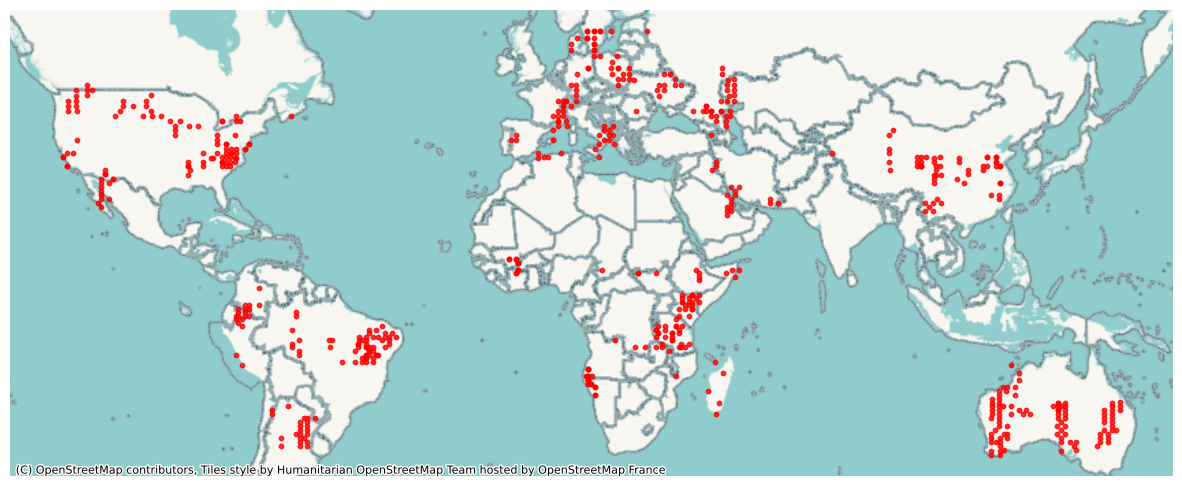

In [5]:
tif_files = glob.glob("HLS2-s30_rgb_raw/*.tif")
points = []
crs_list = []

# Extract the center point of each raster in its native CRS
for tif in tif_files:
    with rasterio.open(tif) as src:
        bounds = src.bounds
        center_x = (bounds.left + bounds.right) / 2
        center_y = (bounds.top + bounds.bottom) / 2
        points.append(Point(center_x, center_y))
        crs_list.append(src.crs)

# Create GeoDataFrame (with the CRS of the first raster as placeholder)
gdf = gpd.GeoDataFrame({'tif_file': tif_files, 'crs_orig': crs_list}, geometry=points, crs=crs_list[0])
reprojected_points = []

for geom, crs in zip(gdf.geometry, gdf.crs_orig):
    g = gpd.GeoSeries([geom], crs=crs).to_crs(epsg=4326)
    reprojected_points.append(g.iloc[0])

gdf = gpd.GeoDataFrame({'tif_file': tif_files}, geometry=reprojected_points, crs="EPSG:4326").to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, color='red', markersize=10, alpha=0.8)
ctx.add_basemap(ax, crs=gdf.crs.to_string())
ax.set_axis_off()
plt.show()

Open up the 2020 [*Global Urban and Rural Settlement*](https://zenodo.org/records/15674281) (GURS) dataset and check the metadata:

In [6]:
with rasterio.open("GURS_2020.tif") as src:
    metadata = {
        'Driver': src.driver,
        'Width (pixels)': src.width,
        'Height (pixels)': src.height,
        'Number of bands': src.count,
        'Data type': src.dtypes[0],
        'CRS': src.crs,
        'Transform (Affine)': src.transform,
        'Bounds': src.bounds,
        'Nodata value': src.nodata,
        'Is tiled': src.is_tiled,
        'Block shapes': src.block_shapes
    }

    unique_values = set()
    for ji, window in src.block_windows(1): # iterate over blocks
        data = src.read(1, window=window)
        unique_values.update(np.unique(data[data != src.nodata]))
    
    metadata['Unique pixel values'] = sorted(unique_values)
    html = "<table style='border:1px solid black; border-collapse: collapse;'>"
    html += "<tr><th style='border:1px solid black; padding:4px;'>Property</th><th style='border:1px solid black; padding:4px;'>Value</th></tr>"
    
    for k, v in metadata.items():
        html += f"<tr><td style='border:1px solid black; padding:4px;'>{k}</td><td style='border:1px solid black; padding:4px; white-space: pre-wrap;'>{v}</td></tr>"
        
    html += "</table>"
    display(HTML(html))

Property,Value
Driver,GTiff
Width (pixels),358509
Height (pixels),133171
Number of bands,1
Data type,uint8
CRS,EPSG:4326
Transform (Affine),"| 0.00, 0.00,-180.00| | 0.00,-0.00, 77.91| | 0.00, 0.00, 1.00|"
Bounds,"BoundingBox(left=-179.99999840575052, bottom=-55.81961353348433, right=179.99948973589213, top=77.90541306372046)"
Nodata value,127.0
Is tiled,True


All of the raw satellite imagery pulled from Planetary Computer is saved on disk at this point. The ground truth dataset has also been sanity checked. Move on to the next notebook to prepare the data for training.